In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [60]:
import pandas as pd
pd.__version__


'2.0.3'

In [34]:
#total airplanes in the fleet
df_fleet = pd.DataFrame({"Model": ["B757", "A340_200", "A340_300"], "Number": [47, 15, 24], "Cost": [56.4, 78.9, 88.5], "Flight_per_day": [6, 2.25, 2]})
df_fleet['annual_flights'] = df_fleet['Flight_per_day']*342*df_fleet['Number']
df_fleet

,Model,Number,Cost,Flight_per_day,annual_flights
0,B757,47,56.4,6.00,96444.0
1,A340_200,15,78.9,2.25,11542.5
2,A340_300,24,88.5,2.00,16416.0


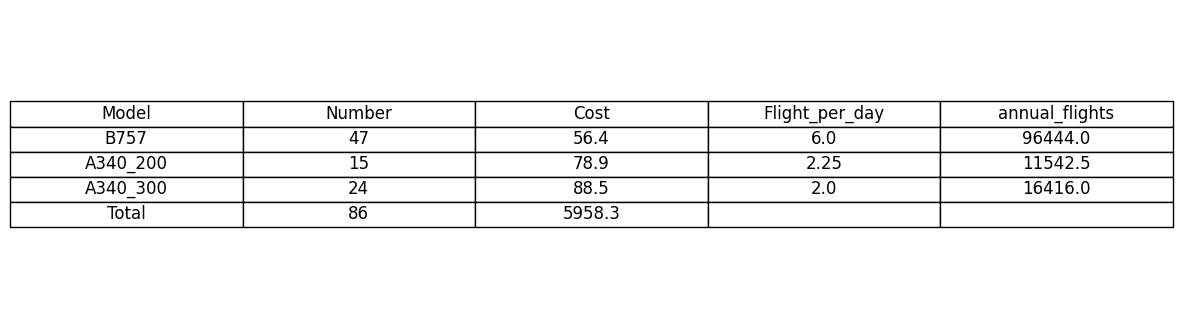

In [62]:
# Your provided dataframe creation code
df_fleet_table = pd.DataFrame({"Model": ["B757", "A340_200", "A340_300"], "Number": [47, 15, 24], "Cost": [56.4, 78.9, 88.5], "Flight_per_day": [6, 2.25, 2]})
df_fleet_table['annual_flights'] = df_fleet_table['Flight_per_day'] * 342 * df_fleet_table['Number']

# Add total values to the dataframe
total_aircraft = df_fleet_table['Number'].sum()
total_cost = round((df_fleet_table['Number'] * df_fleet_table['Cost']).sum(), 2)

df_fleet_display_table = pd.concat([df_fleet_table, pd.DataFrame([{
    'Model': 'Total',
    'Number': total_aircraft,
    'Cost': total_cost,
    'Flight_per_day': '',
    'annual_flights': ''
}])], ignore_index=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Hide axes
ax.axis('off')

# Display the table
tbl = ax.table(cellText=df_fleet_display_table.values, colLabels=df_fleet_display_table.columns, cellLoc='center', loc='center')

# Make the cells larger to fit the text
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)

# Save the figure as an image
plt.savefig('df_fleet_image.png', bbox_inches='tight', dpi=300)

plt.show()

In [35]:
def accidental_cost_calc(n_sim, p_accident, df):
    
    accidental_loss_cost = {}
    for plane in df.Model.unique():
        P_Accident = np.random.binomial(df[df['Model']==plane]['annual_flights'], p_accident, (n_sim,5))
        plane_cost = df[df['Model']==plane]['Cost'].values[0]
        accidental_loss_cost[plane] = P_Accident * plane_cost
        
    return accidental_loss_cost

In [36]:
def total_claim_amount_calc(n_sim, p_accident, df, min_maintenance=1, max_maintenance=5):
    
    total_accidental_cost = np.zeros((n_sim,5))
    accidental_loss_cost = accidental_cost_calc(n_sim, p_accident, df)
    maintenance_cost = np.random.uniform(min_maintenance,max_maintenance,(n_sim,5))
    
    for model in accidental_loss_cost.keys():
        total_accidental_cost += accidental_loss_cost[model]
        
    return total_accidental_cost + maintenance_cost

In [37]:
def insurance_eval(premium,
                    premium_type,
                    variable_premium,
                    deductible, 
                    deductible_type,
                    max_insurance,
                    rebate,
                    fleet_val, 
                    total_claim_amt,
                    name):
    
    if premium_type=='percentage':
        premium_cost = premium*fleet_val
    elif premium_type=='variable':
        premium_cost = premium*fleet_val + variable_premium
    elif premium_type=='fixed':
        premium_cost = premium
    

    if deductible_type=='percentage':
        if max_insurance==np.inf:
            claim_reimbursement = total_claim_amt*(1-deductible)
        else:
            claim_reimbursement = np.minimum(max_insurance,total_claim_amt*(1-deductible))
    else:
        claim_reimbursement = np.maximum(0, total_claim_amt-deductible)
    # print('total_claim_amt',total_claim_amt)
    # print('total_claim_reimburseemt',claim_reimbursement)
    # print('premium',premium_cost)
    
    if rebate==0:
        profits = 0
    else:
        profits = np.maximum(0, premium_cost - claim_reimbursement)*rebate

    # print('profits*rebate',profits)

    final_cost = total_claim_amt - claim_reimbursement + premium_cost - profits

    df = pd.DataFrame({'Title': [name], 'OneYearrCost(in Millions)' : [round(final_cost.mean(axis=1).mean(),2)], 'FiveYearCost(in Millions)': [round(final_cost.mean(axis=1).mean()*5,2)], 'P(X>37)(in %age)' : [round(100*(final_cost>37).mean(),2)]})
    # print(final_cost)
    return  final_cost, df

### Industry Rates

In [38]:
N = 2000000 #2 Million
p_accident = 1/5000000 # 1 in 5 Million
total_fleet_value = ((df_fleet['Cost']*df_fleet['Number']).sum())
master_df = pd.DataFrame()

In [39]:
claim_amount = total_claim_amount_calc(N, p_accident, df_fleet, 1, 5)

In [40]:
#RCNC1
total_insurance_cost, df = insurance_eval(premium=0.0045, 
                                      premium_type='percentage', 
                                      variable_premium=0, 
                                      deductible=0.1, 
                                      deductible_type='percentage', 
                                      max_insurance=np.inf, 
                                      rebate=0.2, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='RCNC1_industry_rate')
master_df = pd.concat([master_df,df],axis=0)

In [41]:
#RCNC2
var_premium = np.minimum(0.9 * claim_amount, 1/100 * total_fleet_value)
total_insurance_cost, df = insurance_eval(premium=0.001, 
                                      premium_type='variable', 
                                      variable_premium = var_premium, 
                                      deductible=0, 
                                      deductible_type='percentage', 
                                      max_insurance=np.inf, 
                                      rebate=0, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='RCNC2_industry_rate')
master_df = pd.concat([master_df,df],axis=0)

In [42]:
#CTC
total_insurance_cost,df = insurance_eval(premium=13, 
                                      premium_type='fixed', 
                                      variable_premium = 0, 
                                      deductible=0.1, 
                                      deductible_type='percentage', 
                                      max_insurance=80, 
                                      rebate=0, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='CTC_industry_rate')
master_df = pd.concat([master_df,df],axis=0)

In [43]:
#HIC
total_insurance_cost,df = insurance_eval(premium=0.00165, 
                                      premium_type='percentage', 
                                      variable_premium = 0, 
                                      deductible=24, 
                                      deductible_type='fixed',
                                      max_insurance=np.inf, 
                                      rebate=0.035, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='HIC_industry_rate')
master_df = pd.concat([master_df,df],axis=0)

In [44]:
master_df

,Title,OneYearrCost(in Millions),FiveYearCost(in Millions),P(X>37)(in %age)
0,RCNC1_industry_rate,22.57,112.83,0.03
0,RCNC2_industry_rate,9.94,49.72,2.46
0,CTC_industry_rate,13.48,67.38,0.03
0,HIC_industry_rate,13.01,65.06,0.00


## Ontario Gateway Rates

In [45]:
N = 2000000 #2 Million
p_accident = 0.75*1/5000000 # 1 in 5 Million * 75%
total_fleet_value = ((df_fleet['Cost']*df_fleet['Number']).sum())

In [46]:
claim_amount = total_claim_amount_calc(N, p_accident, df_fleet, 1, 5)

In [47]:
#RCNC1
total_insurance_cost, df = insurance_eval(premium=0.0045, 
                                      premium_type='percentage', 
                                      variable_premium=0, 
                                      deductible=0.1, 
                                      deductible_type='percentage', 
                                      max_insurance=np.inf, 
                                      rebate=0.2, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='RCNC1_OntarioGateway_rate')
master_df = pd.concat([master_df,df],axis=0)


#RCNC2
var_premium = np.minimum(0.9 * claim_amount, 1/100 * total_fleet_value)
total_insurance_cost, df = insurance_eval(premium=0.001, 
                                      premium_type='variable', 
                                      variable_premium = var_premium, 
                                      deductible=0, 
                                      deductible_type='percentage', 
                                      max_insurance=np.inf, 
                                      rebate=0, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='RCNC2_OntarioGateway_rate')
master_df = pd.concat([master_df,df],axis=0)

#CTC
total_insurance_cost,df = insurance_eval(premium=13, 
                                      premium_type='fixed', 
                                      variable_premium = 0, 
                                      deductible=0.1, 
                                      deductible_type='percentage', 
                                      max_insurance=80, 
                                      rebate=0, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='CTC_OntarioGateway_rate')
master_df = pd.concat([master_df,df],axis=0)

#HIC
total_insurance_cost,df = insurance_eval(premium=0.00165, 
                                      premium_type='percentage', 
                                      variable_premium = 0, 
                                      deductible=24, 
                                      deductible_type='fixed',
                                      max_insurance=np.inf, 
                                      rebate=0.035, 
                                      fleet_val=total_fleet_value, 
                                      total_claim_amt=claim_amount,
                                      name='HIC_OntarioGateway_rate')
master_df = pd.concat([master_df,df],axis=0)

In [48]:
master_df

,Title,OneYearrCost(in Millions),FiveYearCost(in Millions),P(X>37)(in %age)
0,RCNC1_industry_rate,22.57,112.83,0.03
0,RCNC2_industry_rate,9.94,49.72,2.46
0,CTC_industry_rate,13.48,67.38,0.03
0,HIC_industry_rate,13.01,65.06,0.00
0,RCNC1_OntarioGateway_rate,22.50,112.48,0.02
0,RCNC2_OntarioGateway_rate,9.62,48.11,1.85
0,CTC_OntarioGateway_rate,13.43,67.14,0.02
0,HIC_OntarioGateway_rate,12.88,64.41,0.00


In [49]:
master_df['key'] = master_df.Title.apply(lambda x: 'Industry Accident Rate' if 'industry' in x else 'Ontario Gateway Reduced Accident Rates')
master_df['Insurance'] = master_df.Title.apply(lambda x: x.split('_')[0])

RCNC1 Costs Over 1 and 5 years

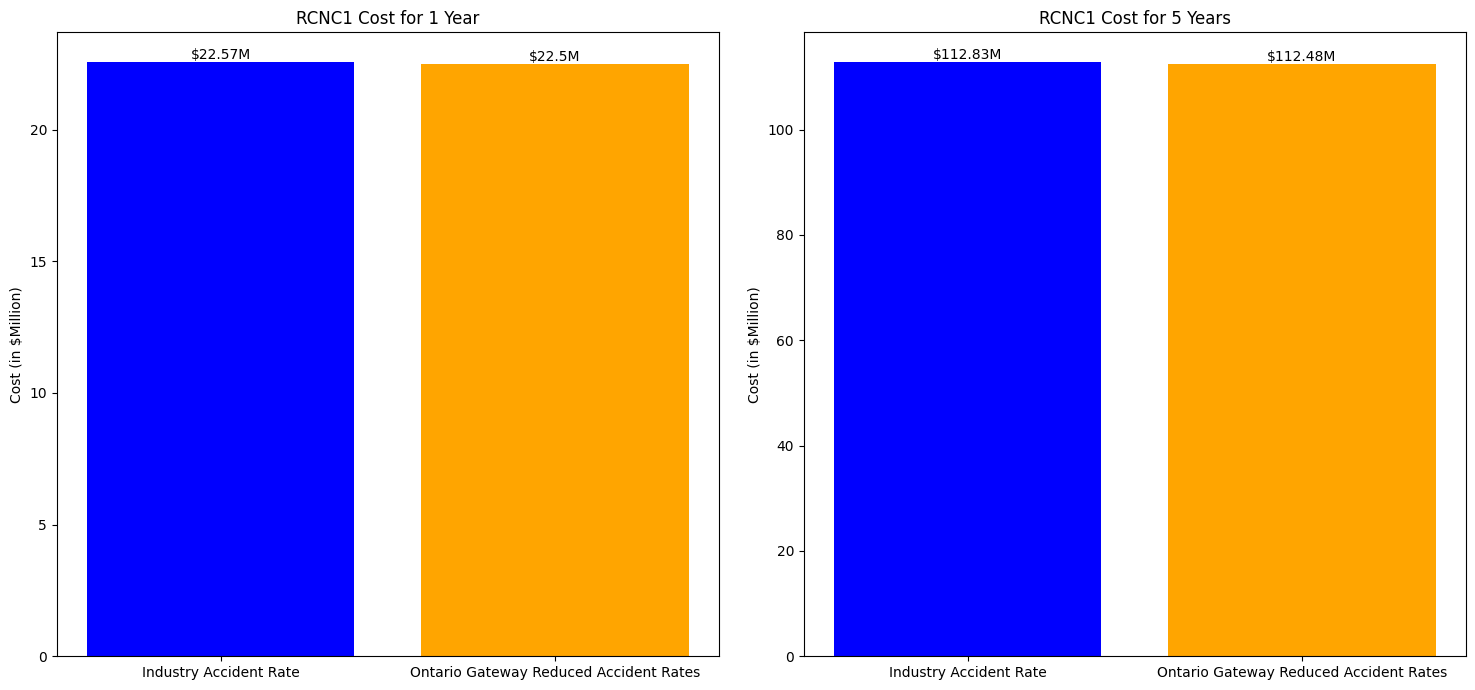

In [50]:
# Extracting costs for RCNC1 from the master_df dataframe
rcnc1_one_year_costs_industry = master_df[(master_df['Title'] == 'RCNC1_industry_rate')]['OneYearrCost(in Millions)'].values[0]
rcnc1_one_year_costs_OG = master_df[(master_df['Title'] == 'RCNC1_OntarioGateway_rate')]['OneYearrCost(in Millions)'].values[0]
rcnc1_five_year_costs_industry = master_df[(master_df['Title'] == 'RCNC1_industry_rate')]['FiveYearCost(in Millions)'].values[0]
rcnc1_five_year_costs_OG = master_df[(master_df['Title'] == 'RCNC1_OntarioGateway_rate')]['FiveYearCost(in Millions)'].values[0]

# Collating the extracted values
one_year_costs = [rcnc1_one_year_costs_industry, rcnc1_one_year_costs_OG]
five_year_costs = [rcnc1_five_year_costs_industry, rcnc1_five_year_costs_OG]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot for one-year cost
ax[0].bar(labels, one_year_costs, color=['blue', 'orange'])
ax[0].set_title('RCNC1 Cost for 1 Year')
ax[0].set_ylabel('Cost (in $Million)')
for i, value in enumerate(one_year_costs):
    ax[0].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

# Bar plot for five-year cost
ax[1].bar(labels, five_year_costs, color=['blue', 'orange'])
ax[1].set_title('RCNC1 Cost for 5 Years')
ax[1].set_ylabel('Cost (in $Million)')
for i, value in enumerate(five_year_costs):
    ax[1].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

plt.savefig('RCNC1 Costs Over 1 and 5 years.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


RCNC2 Costs Over 1 and 5 years

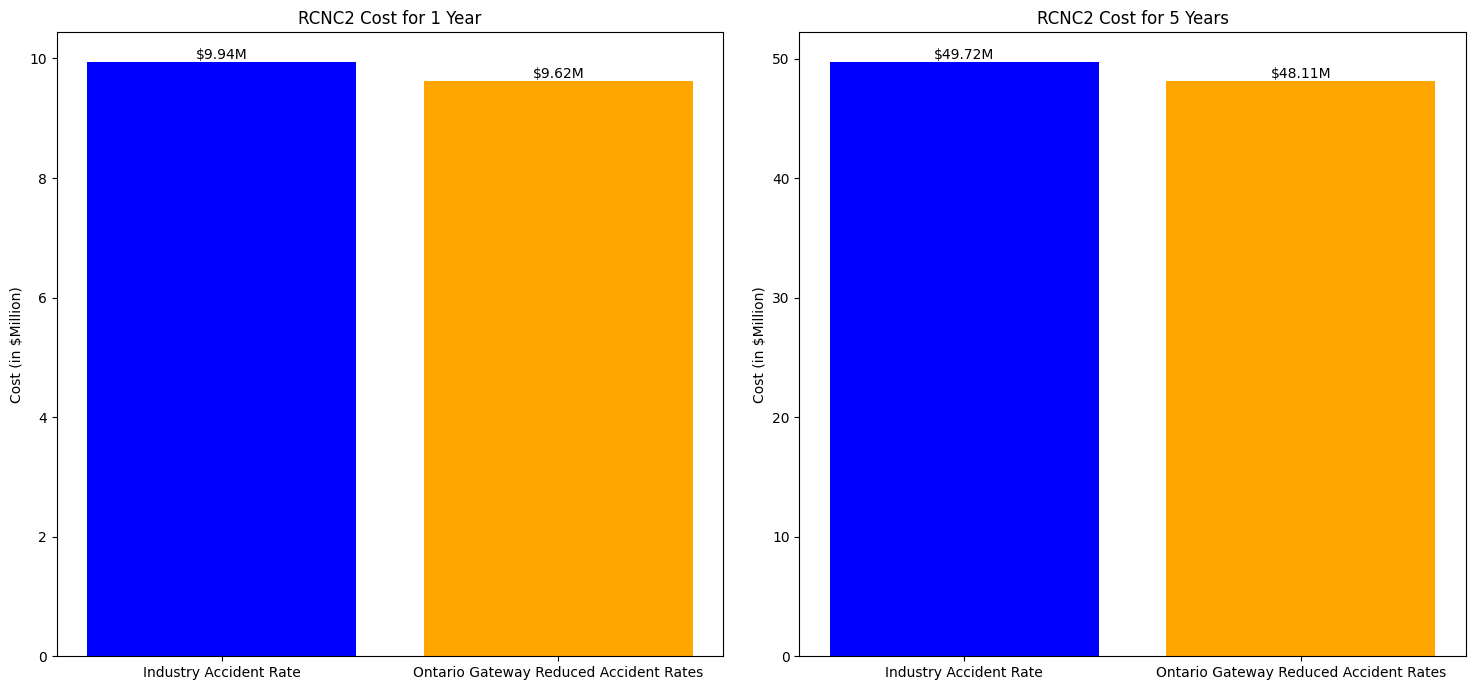

In [51]:
# Extracting costs for RCNC2 from the master_df dataframe
rcnc2_one_year_costs_industry = master_df[(master_df['Title'] == 'RCNC2_industry_rate')]['OneYearrCost(in Millions)'].values[0]
rcnc2_one_year_costs_OG = master_df[(master_df['Title'] == 'RCNC2_OntarioGateway_rate')]['OneYearrCost(in Millions)'].values[0]
rcnc2_five_year_costs_industry = master_df[(master_df['Title'] == 'RCNC2_industry_rate')]['FiveYearCost(in Millions)'].values[0]
rcnc2_five_year_costs_OG = master_df[(master_df['Title'] == 'RCNC2_OntarioGateway_rate')]['FiveYearCost(in Millions)'].values[0]

# Collating the extracted values
one_year_costs = [rcnc2_one_year_costs_industry, rcnc2_one_year_costs_OG]
five_year_costs = [rcnc2_five_year_costs_industry, rcnc2_five_year_costs_OG]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot for one-year cost
ax[0].bar(labels, one_year_costs, color=['blue', 'orange'])
ax[0].set_title('RCNC2 Cost for 1 Year')
ax[0].set_ylabel('Cost (in $Million)')
for i, value in enumerate(one_year_costs):
    ax[0].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

# Bar plot for five-year cost
ax[1].bar(labels, five_year_costs, color=['blue', 'orange'])
ax[1].set_title('RCNC2 Cost for 5 Years')
ax[1].set_ylabel('Cost (in $Million)')
for i, value in enumerate(five_year_costs):
    ax[1].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

plt.savefig('RCNC2 Costs Over 1 and 5 years.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


CTC Costs Over 1 and 5 years

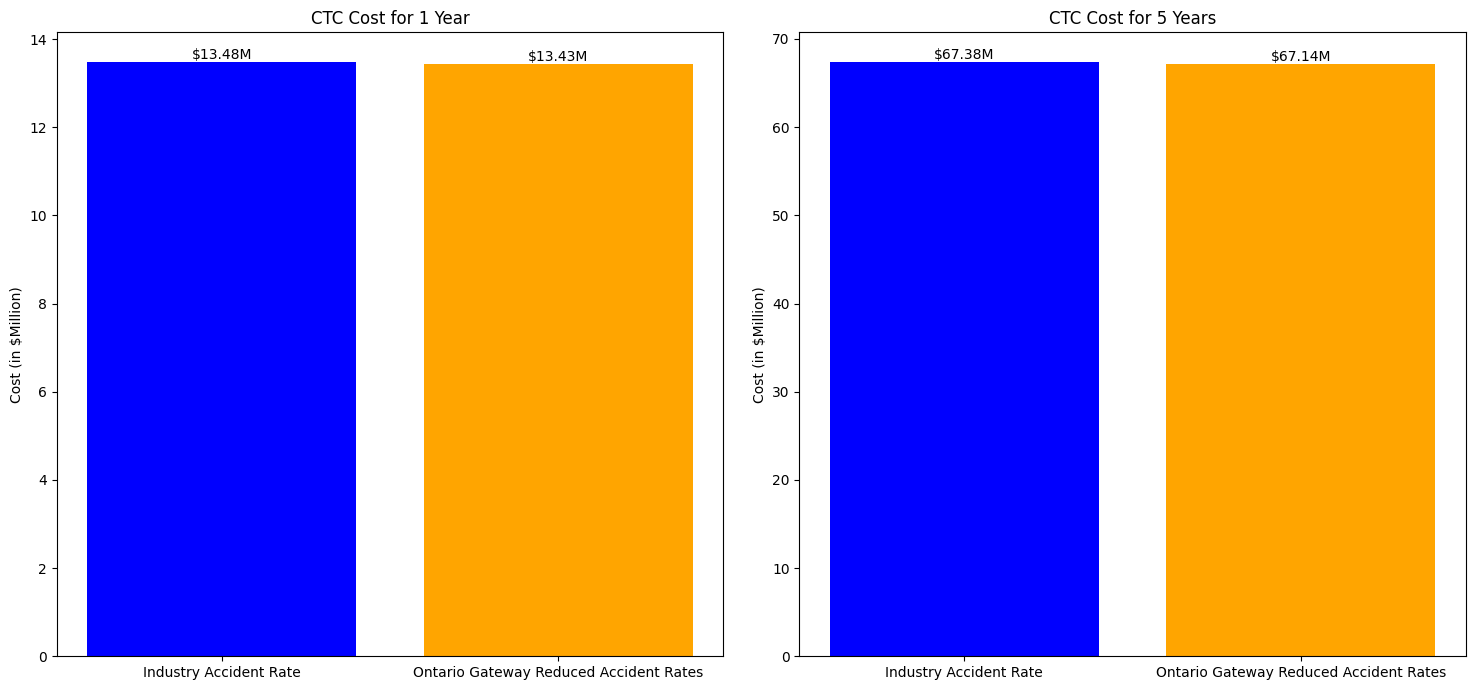

In [52]:
# Extracting costs for CTC from the master_df dataframe
ctc_one_year_costs_industry = master_df[(master_df['Title'] == 'CTC_industry_rate')]['OneYearrCost(in Millions)'].values[0]
ctc_one_year_costs_OG = master_df[(master_df['Title'] == 'CTC_OntarioGateway_rate')]['OneYearrCost(in Millions)'].values[0]
ctc_five_year_costs_industry = master_df[(master_df['Title'] == 'CTC_industry_rate')]['FiveYearCost(in Millions)'].values[0]
ctc_five_year_costs_OG = master_df[(master_df['Title'] == 'CTC_OntarioGateway_rate')]['FiveYearCost(in Millions)'].values[0]

# Collating the extracted values
one_year_costs = [ctc_one_year_costs_industry, ctc_one_year_costs_OG]
five_year_costs = [ctc_five_year_costs_industry, ctc_five_year_costs_OG]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot for one-year cost
ax[0].bar(labels, one_year_costs, color=['blue', 'orange'])
ax[0].set_title('CTC Cost for 1 Year')
ax[0].set_ylabel('Cost (in $Million)')
for i, value in enumerate(one_year_costs):
    ax[0].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

# Bar plot for five-year cost
ax[1].bar(labels, five_year_costs, color=['blue', 'orange'])
ax[1].set_title('CTC Cost for 5 Years')
ax[1].set_ylabel('Cost (in $Million)')
for i, value in enumerate(five_year_costs):
    ax[1].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

plt.savefig('CTC Costs Over 1 and 5 years.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


HIC Costs Over 1 and 5 years

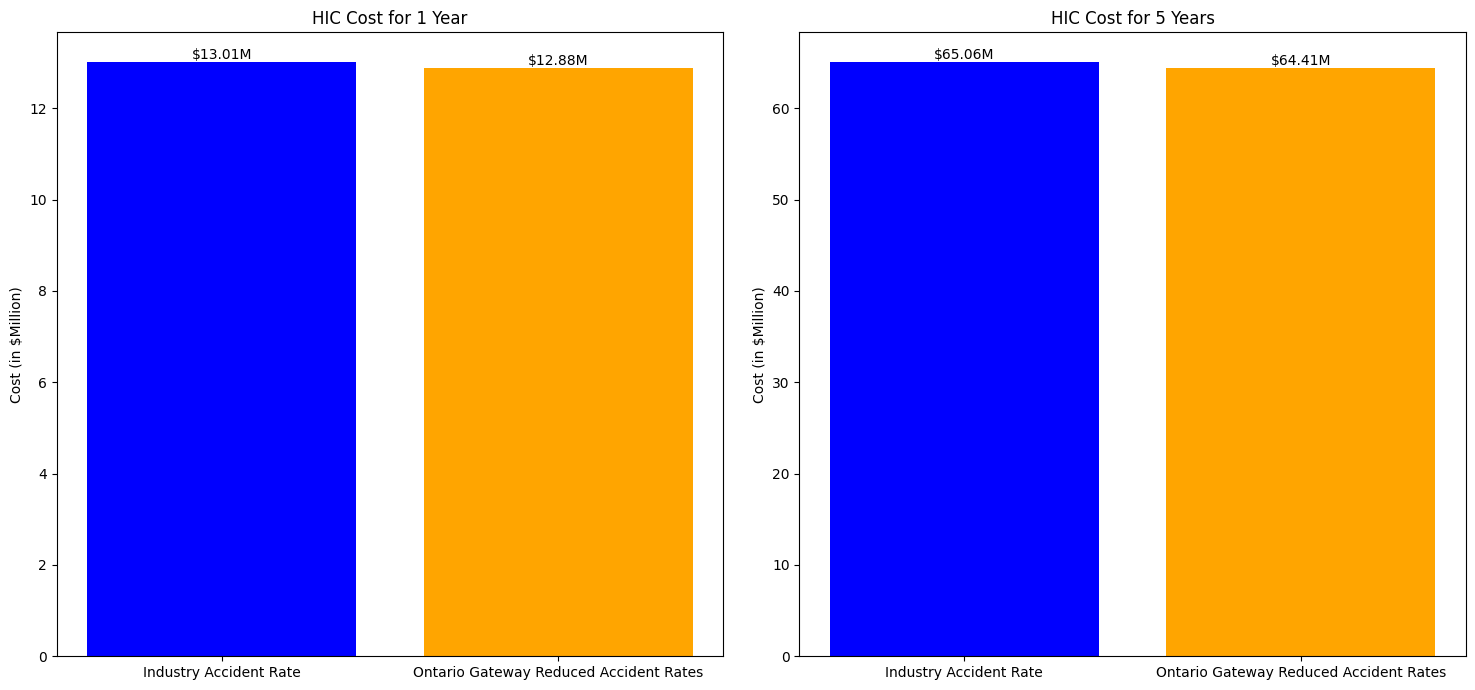

In [53]:
# Extracting costs for HIC from the master_df dataframe
hic_one_year_costs_industry = master_df[(master_df['Title'] == 'HIC_industry_rate')]['OneYearrCost(in Millions)'].values[0]
hic_one_year_costs_OG = master_df[(master_df['Title'] == 'HIC_OntarioGateway_rate')]['OneYearrCost(in Millions)'].values[0]
hic_five_year_costs_industry = master_df[(master_df['Title'] == 'HIC_industry_rate')]['FiveYearCost(in Millions)'].values[0]
hic_five_year_costs_OG = master_df[(master_df['Title'] == 'HIC_OntarioGateway_rate')]['FiveYearCost(in Millions)'].values[0]

# Collating the extracted values
one_year_costs = [hic_one_year_costs_industry, hic_one_year_costs_OG]
five_year_costs = [hic_five_year_costs_industry, hic_five_year_costs_OG]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot for one-year cost
ax[0].bar(labels, one_year_costs, color=['blue', 'orange'])
ax[0].set_title('HIC Cost for 1 Year')
ax[0].set_ylabel('Cost (in $Million)')
for i, value in enumerate(one_year_costs):
    ax[0].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

# Bar plot for five-year cost
ax[1].bar(labels, five_year_costs, color=['blue', 'orange'])
ax[1].set_title('HIC Cost for 5 Years')
ax[1].set_ylabel('Cost (in $Million)')
for i, value in enumerate(five_year_costs):
    ax[1].text(i, value, '$'+str(value)+'M', ha='center', va='bottom')

plt.savefig('HIC Costs Over 1 and 5 years.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


RCNC2 Vs HIC Costs Over 1 and 5 years

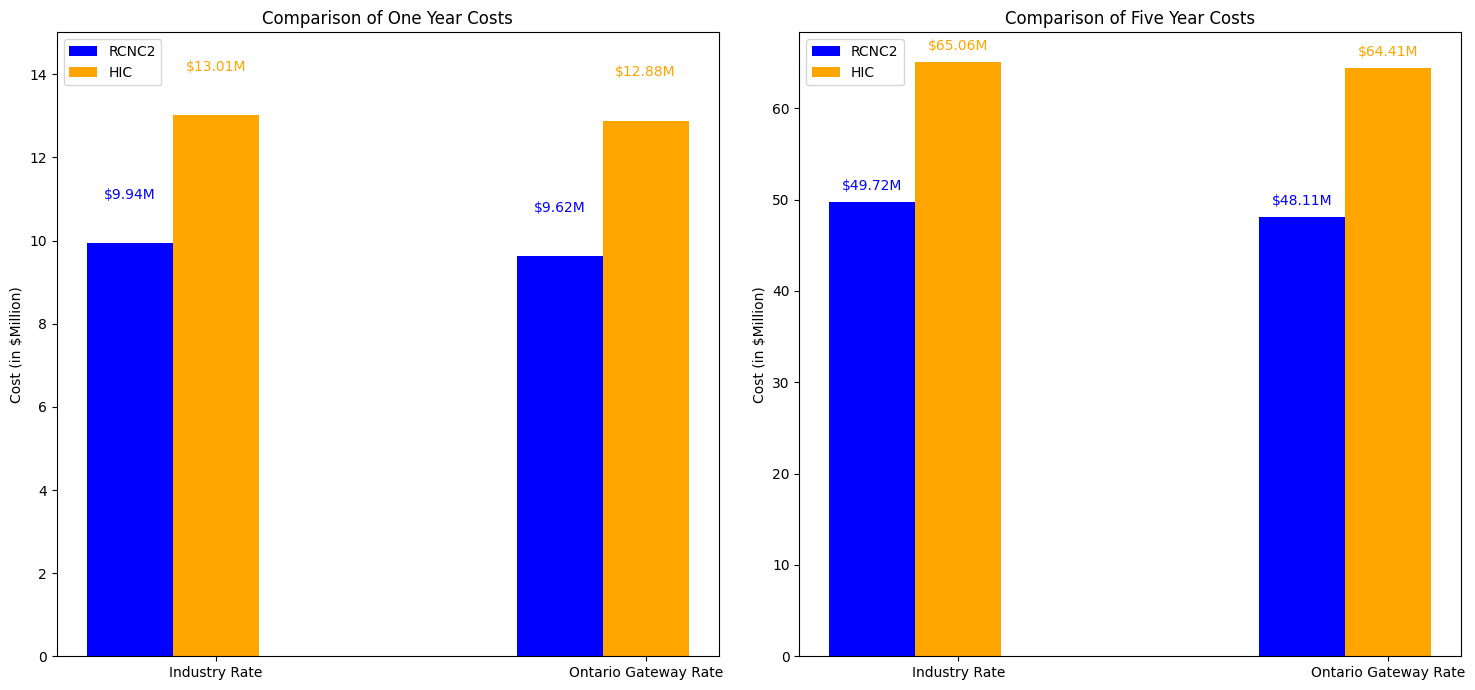

In [72]:
# Extracting costs from master_df dataframe
rcnc2_one_year_costs = [
    master_df[(master_df['Title'] == 'RCNC2_industry_rate')]['OneYearrCost(in Millions)'].values[0],
    master_df[(master_df['Title'] == 'RCNC2_OntarioGateway_rate')]['OneYearrCost(in Millions)'].values[0]
]
hic_one_year_costs = [
    master_df[(master_df['Title'] == 'HIC_industry_rate')]['OneYearrCost(in Millions)'].values[0],
    master_df[(master_df['Title'] == 'HIC_OntarioGateway_rate')]['OneYearrCost(in Millions)'].values[0]
]

rcnc2_five_year_costs = [
    master_df[(master_df['Title'] == 'RCNC2_industry_rate')]['FiveYearCost(in Millions)'].values[0],
    master_df[(master_df['Title'] == 'RCNC2_OntarioGateway_rate')]['FiveYearCost(in Millions)'].values[0]
]
hic_five_year_costs = [
    master_df[(master_df['Title'] == 'HIC_industry_rate')]['FiveYearCost(in Millions)'].values[0],
    master_df[(master_df['Title'] == 'HIC_OntarioGateway_rate')]['FiveYearCost(in Millions)'].values[0]
]

# Setting up the positions and width for the bars
barWidth = 0.2
r1 = np.arange(2)  # Positions for RCNC2
r2 = [x + barWidth for x in r1]  # Positions for HIC

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot for one-year cost
ax[0].bar(r1, rcnc2_one_year_costs, color='blue', width=barWidth, label='RCNC2')
ax[0].bar(r2, hic_one_year_costs, color='orange', width=barWidth, label='HIC')

# Adjusting y-axis limit for the first graph
ax[0].set_ylim(0, max(hic_one_year_costs) + 2)  # Increase the maximum y-axis value by 4 million


# Displaying the values above the bars
for i, v in enumerate(rcnc2_one_year_costs):
    ax[0].text(i, v + 1, "$" + str(v) + "M", ha='center', va='bottom', color='blue')
for i, v in enumerate(hic_one_year_costs):
    ax[0].text(i + barWidth, v + 1, "$" + str(v) + "M", ha='center', va='bottom', color='orange')

ax[0].set_xticks([r + barWidth for r in range(2)])
ax[0].set_xticklabels(['Industry Rate', 'Ontario Gateway Rate'])
ax[0].set_title('Comparison of One Year Costs')
ax[0].set_ylabel('Cost (in $Million)')
ax[0].legend(loc='upper left')  # Moved the legend to the left side

# Bar plot for five-year cost
ax[1].bar(r1, rcnc2_five_year_costs, color='blue', width=barWidth, label='RCNC2')
ax[1].bar(r2, hic_five_year_costs, color='orange', width=barWidth, label='HIC')

# Displaying the values above the bars
for i, v in enumerate(rcnc2_five_year_costs):
    ax[1].text(i, v + 1, "$" + str(v) + "M", ha='center', va='bottom', color='blue')
for i, v in enumerate(hic_five_year_costs):
    ax[1].text(i + barWidth, v + 1, "$" + str(v) + "M", ha='center', va='bottom', color='orange')

ax[1].set_xticks([r + barWidth for r in range(2)])
ax[1].set_xticklabels(['Industry Rate', 'Ontario Gateway Rate'])
ax[1].set_title('Comparison of Five Year Costs')
ax[1].set_ylabel('Cost (in $Million)')
ax[1].legend()

plt.tight_layout()
plt.savefig('RCNC2 Vs HIC Costs Over 1 and 5 years.png', dpi=300, bbox_inches='tight')
plt.show()


Cost of Insurance over 1 Year

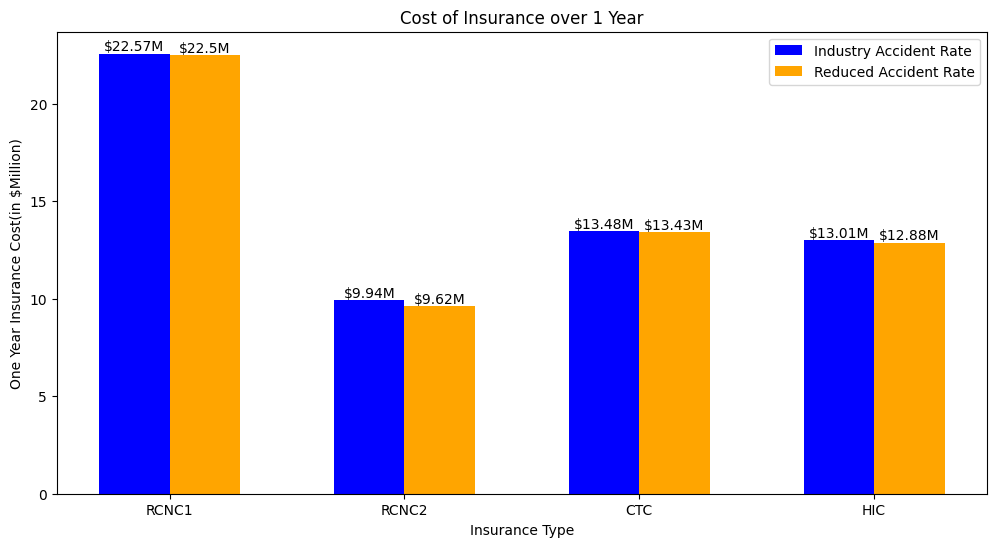

In [55]:
# Values for plotting
ind = np.arange(4)
width = 0.3

# Extracting one year costs for each rate
blue_bar_1yr = master_df[master_df.key=='Industry Accident Rate']['OneYearrCost(in Millions)']
orange_bar_1yr = master_df[master_df.key=='Ontario Gateway Reduced Accident Rates']['OneYearrCost(in Millions)']

# Plotting
plt.figure(figsize=(12,6))
plt.xticks(ind + width / 2, master_df[master_df.key=='Industry Accident Rate']['Insurance'])

# Bar plots with blue for 'Industry Accident Rate' and orange for 'Reduced Accident Rate'
plt.bar(ind, blue_bar_1yr, width, color='blue', label='Industry Accident Rate')
plt.bar(ind + width, orange_bar_1yr, width, color='orange', label='Reduced Accident Rate')

# Labelling and titles
plt.xlabel('Insurance Type')
plt.ylabel('One Year Insurance Cost(in $Million)')
plt.title('Cost of Insurance over 1 Year')
plt.legend(loc='best')

# Text for bar values
for i, value in enumerate(blue_bar_1yr):
    plt.text(ind[i], value, '$'+str(value)+'M', ha='center', va='bottom')
for i, value in enumerate(orange_bar_1yr):
    plt.text(ind[i]+width, value, '$'+str(value)+'M', ha='center', va='bottom')

plt.savefig('Cost of Insurance over 1 Year.png', dpi=300, bbox_inches='tight')

plt.show()


Cost of Insurance over 5 Years

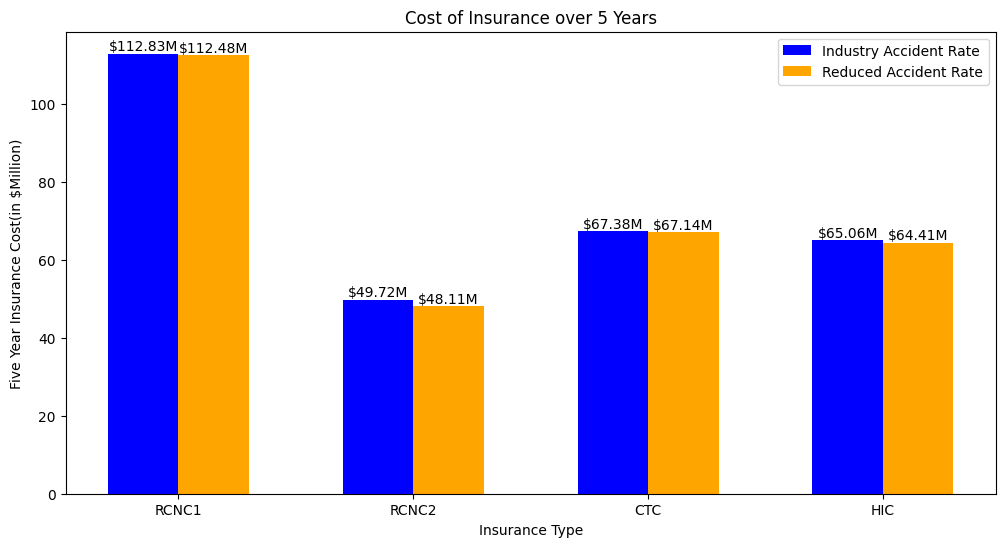

In [56]:
ind = np.arange(4)
width = 0.3

blue_bar = master_df[master_df.key=='Industry Accident Rate']['FiveYearCost(in Millions)']
orange_bar = master_df[master_df.key=='Ontario Gateway Reduced Accident Rates']['FiveYearCost(in Millions)']

plt.figure(figsize=(12,6))
plt.xticks(ind + width / 2, master_df[master_df.key=='Industry Accident Rate']['Insurance'])

# Bar plots with blue for 'Industry Accident Rate' and orange for 'Reduced Accident Rate'
plt.bar(ind, blue_bar, width, color='blue', label='Industry Accident Rate')
plt.bar(ind + width, orange_bar, width, color='orange', label='Reduced Accident Rate')

plt.xlabel('Insurance Type')
plt.ylabel('Five Year Insurance Cost(in $Million)')
plt.title('Cost of Insurance over 5 Years')
plt.legend(loc='best')

for i, value in enumerate(blue_bar):
    plt.text(ind[i], value, '$'+str(value)+'M', ha='center', va='bottom')

for i, value in enumerate(orange_bar):
    plt.text(ind[i]+width, value, '$'+str(value)+'M', ha='center', va='bottom')

plt.savefig('Cost of Insurance over 5 Years.png', dpi=300, bbox_inches='tight')

plt.show()


Probability of Insurance Costs Exceeding 37 Million

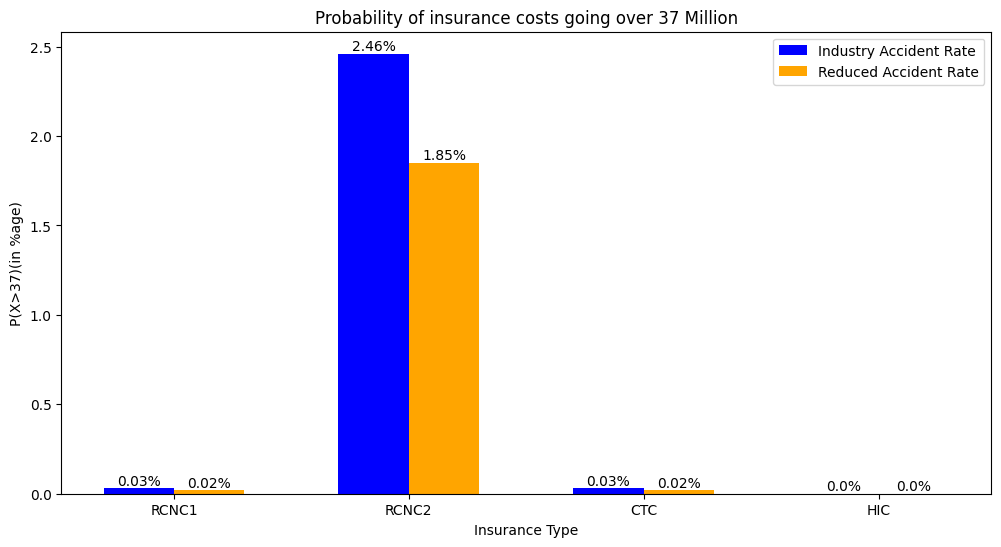

In [57]:
import matplotlib.pyplot as plt

ind = np.arange(4)
width = 0.3

blue_bar = master_df[master_df.key=='Industry Accident Rate']['P(X>37)(in %age)']
orange_bar = master_df[master_df.key=='Ontario Gateway Reduced Accident Rates']['P(X>37)(in %age)']

plt.figure(figsize=(12,6))
plt.xticks(ind + width / 2, master_df[master_df.key=='Industry Accident Rate']['Insurance'])

# Bar plots with blue for 'Industry Accident Rate' and orange for 'Reduced Accident Rate'
plt.bar(ind, blue_bar, width, color='blue', label='Industry Accident Rate')
plt.bar(ind + width, orange_bar, width, color='orange', label='Reduced Accident Rate')

plt.xlabel('Insurance Type')
plt.ylabel('P(X>37)(in %age)')
plt.title('Probability of insurance costs going over 37 Million')
plt.legend(loc='best')

for i, value in enumerate(blue_bar):
    plt.text(ind[i], value, str(value)+'%', ha='center', va='bottom')

for i, value in enumerate(orange_bar):
    plt.text(ind[i]+width, value, str(value)+'%', ha='center', va='bottom')

plt.savefig('Cost of Insurance over 5 Years.png', dpi=300, bbox_inches='tight')

plt.show()
